## Imports


In [280]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter

from gensim.models import FastText

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from sklearn.metrics import accuracy_score, classification_report

import torch
from transformers import AutoTokenizer, AutoModel
from transformers import RobertaModel, RobertaTokenizer
from concurrent.futures import ProcessPoolExecutor


# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Embedding, Flatten
from keras.utils import to_categorical
from keras.layers import Dropout

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\husse\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\husse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [281]:
df = pd.read_csv('Emotional-Tone-Dataset.csv').head(1000)
df = df.drop('ID', axis=1)
df.columns = ['text', 'emotion']
df

,text,emotion
0,الاوليمبياد الجايه هكون لسه ف الكليه ..,none
1,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,anger
2,كتنا نيله ف حظنا الهباب xD,sadness
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,joy
4,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,none
...,...,...
995,الي الكنترول انهارده اخر يوم حرام علي امك بقي ...,anger
996,انا مش عارفه بعد ما الاوليمبياد تخلص هقعد اعمل...,fear
997,مُش معقول!!,surprise
998,انا هنتحر,sadness


In [282]:
# # to tae equaly from each class
# rows_per_class = 200
# result = df.groupby('emotion').head(rows_per_class)

# df = result.copy()
# df = df.reset_index(drop=True)

# df

In [283]:
df['emotion'].unique()

array(['none', 'anger', 'sadness', 'joy', 'surprise', 'love', 'sympathy',
       'fear'], dtype=object)

In [284]:
emotion_counts = df['emotion'].value_counts()
total_samples = len(df)

for emotion, count in emotion_counts.items():
    percentage = (count / total_samples) * 100
    print(f"{emotion}: Count = {count} -----------------> Percentage = {percentage:.2f}%")
print("df shape :",f"{df.shape}")
    

none: Count = 154 -----------------> Percentage = 15.40%
anger: Count = 141 -----------------> Percentage = 14.10%
love: Count = 140 -----------------> Percentage = 14.00%
sadness: Count = 126 -----------------> Percentage = 12.60%
joy: Count = 122 -----------------> Percentage = 12.20%
fear: Count = 108 -----------------> Percentage = 10.80%
surprise: Count = 106 -----------------> Percentage = 10.60%
sympathy: Count = 103 -----------------> Percentage = 10.30%
df shape : (1000, 2)


<Axes: title={'center': 'Count of each emotion'}>

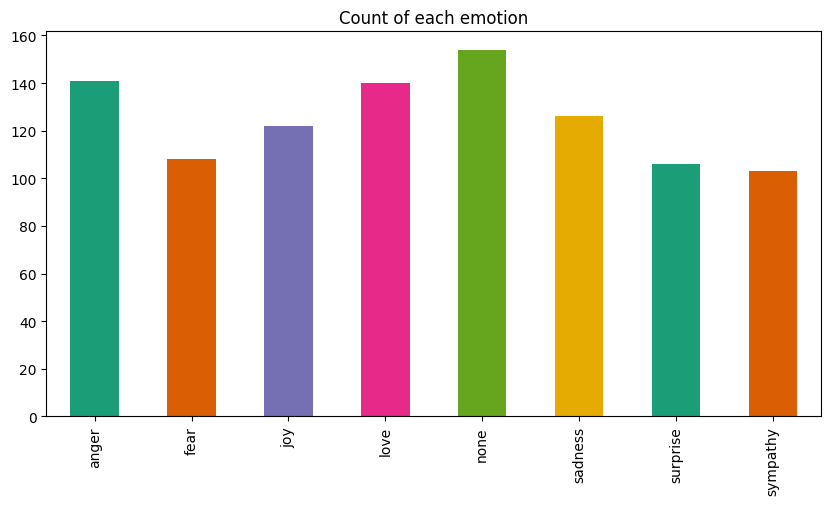

In [285]:
df['emotion'].value_counts().sort_index().plot(kind='bar', title='Count of each emotion', figsize=(10,5),color=sns.palettes.mpl_palette('Dark2'))

## a) Step 1 : Preprocessing



In [286]:
# List of Arabic stopwords
arabic_stopwords = stopwords.words('arabic')

def clean_text(text):
    # Remove any non Arabic unicode
    text = re.sub(r'[^\u0600-\u06FF\s]+', ' ', text)
    # Remove username "@handle" from text
    text = re.sub(r'@\w+', '', text)
    # Remove URL from text
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation, emoji, and smileys from text
    text = re.sub(r'(?<=\w)[^\s\w](?![^\s\w])', '', text)
    # Remove escape codes like \n, \t, \, etc from text
    text = re.sub(r'(\n|\t|\"|\')', '', text)
    # Remove Arabic Diacritization (tashkeel) like fatha, damma, kasra, shaddah, ...
    text = re.sub(r'[\u064B-\u0652]', '', text)
    # Removing Digits
    text = re.sub(r'\d', '', text)


    # Tokenize the text
    words = word_tokenize(text)
    # Remove Arabic stopwords
    words = [word for word in words if word not in arabic_stopwords]

    words = ' '.join(words)
    return words

# Apply the clean_and_tokenize function to the 'text' column
df['cleanedText'] = df['text'].apply(clean_text)
df


,text,emotion,cleanedText
0,الاوليمبياد الجايه هكون لسه ف الكليه ..,none,الاوليمبياد الجايه هكون لسه الكليه
1,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,anger,عجز الموازنه وصل الناتج المحلي يعني لسه اقل نف...
2,كتنا نيله ف حظنا الهباب xD,sadness,كتنا نيله حظنا الهباب
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,joy,جميعنا نريد تحقيق اهدافنا تونس تالقت حراسه المرمي
4,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,none,الاوليمبياد نظامها مختلف ومواعيد المونديال مكا...
...,...,...,...
995,الي الكنترول انهارده اخر يوم حرام علي امك بقي ...,anger,الي الكنترول انهارده اخر يوم حرام علي امك بقي ...
996,انا مش عارفه بعد ما الاوليمبياد تخلص هقعد اعمل...,fear,انا مش عارفه الاوليمبياد تخلص هقعد اعمل ايه اح...
997,مُش معقول!!,surprise,مش معقول
998,انا هنتحر,sadness,انا هنتحر


In [287]:
sample_text = "مرحبًا! @username Check out this link: http://example.com. كيف حالك اليوم ؟ 🌟"
result = clean_text(sample_text)
print(result)

مرحبا حالك اليوم ؟


In [288]:
all_words = [word for sublist in df['cleanedText'] for word in sublist]
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(10)  # Change 10 to the desired number of words
print(most_common_words)

[(' ', 10210), ('ا', 9493), ('ل', 5827), ('ي', 5145), ('م', 3288), ('و', 3023), ('ه', 2967), ('ن', 2660), ('ب', 2630), ('ر', 2484)]


## b) Step 2: The usage of Word Embedding
+ AraBERT


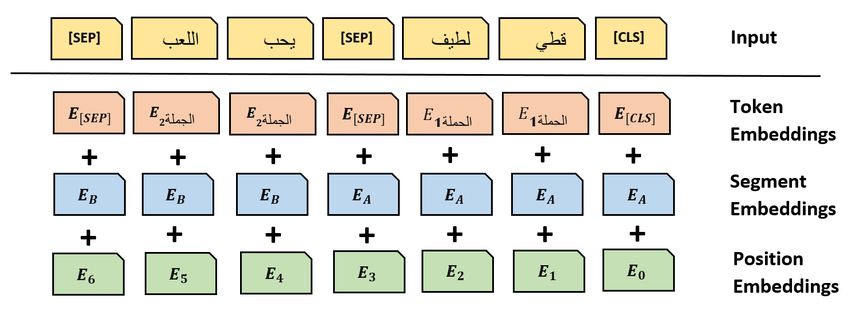

In [2]:
model_name = "aubmindlab/bert-base-arabertv02"
AraBERT_tokenizer = AutoTokenizer.from_pretrained(model_name, output_hidden_states=True)
AraBERT_model = AutoModel.from_pretrained(model_name)

In [292]:
def get_arabert_embedding(text):
    # Tokenize the text
    tokens = AraBERT_tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    # Get the model output
    with torch.no_grad():
        model_output = AraBERT_model(**tokens)
    # Return the embeddings for the [CLS] token
    return model_output.last_hidden_state[:, 0, :].numpy()

In [293]:
# Apply the get_arabert_embedding function to the 'cleanedText' column
df['arabert_embedding'] = df['cleanedText'].apply(get_arabert_embedding)

In [294]:
df

,text,emotion,cleanedText,arabert_embedding
0,الاوليمبياد الجايه هكون لسه ف الكليه ..,none,الاوليمبياد الجايه هكون لسه الكليه,"[[0.32768285, -0.5181918, 0.06737751, -1.42059..."
1,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,anger,عجز الموازنه وصل الناتج المحلي يعني لسه اقل نف...,"[[-0.37491006, -1.5095029, -0.3598289, -0.8258..."
2,كتنا نيله ف حظنا الهباب xD,sadness,كتنا نيله حظنا الهباب,"[[0.20411977, 0.5643407, 0.08659431, -1.213814..."
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,joy,جميعنا نريد تحقيق اهدافنا تونس تالقت حراسه المرمي,"[[-0.06429669, -0.7303029, -0.13922364, -0.592..."
4,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,none,الاوليمبياد نظامها مختلف ومواعيد المونديال مكا...,"[[0.36728913, -1.1709914, -0.042227525, -0.112..."
...,...,...,...,...
995,الي الكنترول انهارده اخر يوم حرام علي امك بقي ...,anger,الي الكنترول انهارده اخر يوم حرام علي امك بقي ...,"[[-0.48713517, 0.24237752, -0.6059217, -1.5234..."
996,انا مش عارفه بعد ما الاوليمبياد تخلص هقعد اعمل...,fear,انا مش عارفه الاوليمبياد تخلص هقعد اعمل ايه اح...,"[[-0.25322205, -0.7574422, -0.10787754, -0.790..."
997,مُش معقول!!,surprise,مش معقول,"[[1.2739047, -0.14573395, -0.37586367, -0.8050..."
998,انا هنتحر,sadness,انا هنتحر,"[[0.04206711, -0.1571647, 0.10179282, -1.02258..."


In [296]:
# example_text = "أهلاً بك في عالم البرمجة"
example_text = df['cleanedText'][2]
embedding = get_arabert_embedding(example_text)
print("AraBERT Embedding for the Example Text:")
# print(embedding)

AraBERT Embedding for the Example Text:


In [324]:
X = df['arabert_embedding'].astype(str).tolist()
y = df['emotion']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'][1])
X_sequences = tokenizer.texts_to_sequences(X)

X_padded = pad_sequences(X_sequences)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [327]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (800, 214)
X_test shape: (200, 214)
y_train shape: (800,)
y_test shape: (200,)


In [ ]:
# np.save('X_train.npy', X_train)
# np.save('X_test.npy', X_test)
# np.save('y_train.npy', y_train)
# np.save('y_test.npy', y_test)

In [ ]:
# X_train = np.load('X_train.npy')
# X_test = np.load('X_test.npy')
# y_train = np.load('y_train.npy')
# y_test = np.load('y_test.npy')

In [336]:
from keras.layers import Masking
# CNN
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_train.shape[1]))
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(8, activation='softmax'))

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_cnn.fit(X_train, y_train, epochs=10, batch_size=32)

y_pred_cnn = np.argmax(model_cnn.predict(X_test), axis=1)
accuracy_cnn = accuracy_score(y_test, y_pred_cnn) 

print(f"CNN Model Accuracy: {accuracy_cnn * 100:.2f}%")

Epoch 1/10
25/25 [==============================] - 1s 10ms/step - loss: 2.0798 - accuracy: 0.1187
Epoch 2/10
25/25 [==============================] - 0s 10ms/step - loss: 2.0766 - accuracy: 0.1425
Epoch 3/10
25/25 [==============================] - 0s 9ms/step - loss: 2.0700 - accuracy: 0.1425
Epoch 4/10
25/25 [==============================] - 0s 9ms/step - loss: 2.0699 - accuracy: 0.1513
Epoch 5/10
25/25 [==============================] - 0s 9ms/step - loss: 2.0678 - accuracy: 0.1513
Epoch 6/10
25/25 [==============================] - 0s 10ms/step - loss: 2.0682 - accuracy: 0.1525
Epoch 7/10
25/25 [==============================] - 0s 10ms/step - loss: 2.0676 - accuracy: 0.1650
Epoch 8/10
25/25 [==============================] - 0s 10ms/step - loss: 2.0671 - accuracy: 0.1350
Epoch 9/10
25/25 [==============================] - 0s 10ms/step - loss: 2.0645 - accuracy: 0.1513
Epoch 10/10
7/7 [==============================] - 0s 3ms/step
CNN Model Accuracy: 15.50%


In [ ]:
# from sklearn.metrics import classification_report
# X_train, X_test, y_train, y_test = train_test_split(df['fineText'], df['dialect'], test_size=0.2, random_state=42) # Splitting data into train and test with 0.8 train and 0.2 test

# def word_embeddings(text): # fuction that takes text
#     tokens = word_tokenize(text) # tokenizes the input
#     return [token for token in tokens if token in ftext.key_to_index] # returns a list of tokens that are present in -----> ftext.key_to_index.

# vectorizer = CountVectorizer(tokenizer=word_embeddings, preprocessor=None, lowercase=False) # used to tokenize the text data
# X_train_transformed = vectorizer.fit_transform(X_train)

# # Splitting training data into batches and training the Naive Bayes model: This section sets the batch_size
# # to 100 and initializes a MultinomialNB model named nb_model. It then loops through the training data in
# # batches of size batch_size and uses the partial_fit method of nb_model to train
# batch_size = 100
# nb_model = MultinomialNB()
# for i in range(0, X_train_transformed.shape[0], batch_size):
#     end = min(i + batch_size, X_train_transformed.shape[0])
#     nb_model.partial_fit(X_train_transformed[i:end], y_train[i:end], classes=df['dialect'].unique())


# X_test_transformed = vectorizer.transform(X_test) # Transforming the test data and calculating accuracy
# accuracy = nb_model.score(X_test_transformed, y_test)
# accuracy = accuracy*100
# print("Naive Bayes Accuracy:", accuracy,'%')


# y_pred = nb_model.predict(X_test_transformed)
# #  classification report
# report = classification_report(y_test, y_pred)
# print("Classification Report:")
# print(report)


## c) Step 3: Models Development

prepares data for emotion detection using NLP. It uses Arabert embeddings,

encodes emotions with LabelEncoder, tokenizes text, and pads sequences for training and testing.

Splitting data into train and test sets is done with a 20% test size and a random seed of 42.

In [ ]:
X = df['arabert_embeddings'].astype(str).tolist()
y = df['emotion']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

X_padded = pad_sequences(X_sequences)

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [ ]:
# random_state=SEED ensures reproducibility
# stratify=y means that the split will maintain the same class distribution in both the training and testing sets
# SEED = 123
# X_train,X_test,y_train,y_test=train_test_split(X_padded, y, test_size=0.2, random_state=SEED, stratify=y)

In [ ]:
print("Type of X_train:", type(X_train))
print("Type of X_test:", type(X_test))
print("Type of y_train:", type(y_train))
print("Type of y_test:", type(y_test))

Type of X_train: <class 'numpy.ndarray'>
Type of X_test: <class 'numpy.ndarray'>
Type of y_train: <class 'numpy.ndarray'>
Type of y_test: <class 'numpy.ndarray'>


In [ ]:
# from imblearn.over_sampling import RandomOverSampler

# # oversampler  = RandomOverSampler(sampling_strategy='auto')
# # X_train_resampled, y_train_resampled = oversampler .fit_resample(X_train, y_train)

# oversample = RandomOverSampler(sampling_strategy='auto')
# X_resampled, y_resampled = oversample.fit_resample(X_padded, y)

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_train.shape[1]))
model_lstm.add(Bidirectional(LSTM(64, return_sequences=True)))
model_lstm.add(Dropout(0.5))  
model_lstm.add(Bidirectional(LSTM(32)))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.5)) 
model_lstm.add(Dense(8, activation='softmax'))

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])   

# model_lstm.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.1)
model_lstm.fit(X_resampled, y_resampled, epochs=8, batch_size=32, validation_split=0.1) # oversapmling

y_pred_lstm = np.argmax(model_lstm.predict(X_test), axis=1)
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)


print(f"LSTM Model Accuracy: {accuracy_lstm * 100:.2f}%")

In [ ]:
# from keras.models import save_model

# # Assuming your model is named model_lstm
# model_lstm.save("bi_lstm-4000.h5")

c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# class_names = label_encoder.classes_
# y_test_names = label_encoder.inverse_transform(y_test)
# y_pred_names = label_encoder.inverse_transform(y_pred_lstm)

# report = classification_report(y_test_names, y_pred_names, target_names=class_names)
# print("LSTM Model Classification Report:\n", report)

LSTM Model Classification Report:
               precision    recall  f1-score   support

       anger       0.75      1.00      0.86        12
        fear       0.82      0.82      0.82        11
         joy       0.72      1.00      0.84        13
        love       1.00      0.54      0.70        13
        none       0.93      0.93      0.93        15
     sadness       0.92      0.92      0.92        13
    surprise       0.85      0.92      0.88        12
    sympathy       0.86      0.55      0.67        11

    accuracy                           0.84       100
   macro avg       0.86      0.83      0.83       100
weighted avg       0.86      0.84      0.83       100



- CNN

In [ ]:
# # CNN
# model_cnn = Sequential()
# model_cnn.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_padded.shape[1]))
# model_cnn.add(Conv1D(128, 5, activation='relu'))
# model_cnn.add(Dropout(0.5))
# model_cnn.add(GlobalMaxPooling1D())
# model_cnn.add(Dense(64, activation='relu'))
# model_cnn.add(Dropout(0.5))
# model_cnn.add(Dense(8, activation='softmax'))

# model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model_cnn.fit(X_resampled, y_resampled, epochs=10, batch_size=32, validation_split=0.1)

# y_pred_cnn = np.argmax(model_cnn.predict(X_test), axis=1)
# accuracy_cnn = accuracy_score(y_test, y_pred_cnn) 
# print(f"CNN Model Accuracy: {accuracy_cnn * 100:.2f}%")

In [ ]:
# class_names = label_encoder.classes_
# y_test_names = label_encoder.inverse_transform(y_test)
# y_pred_names = label_encoder.inverse_transform(y_pred_cnn)

# report = classification_report(y_test_names, y_pred_names, target_names=class_names)
# print("CNN Model Classification Report:\n", report)

CNN Model Classification Report:
               precision    recall  f1-score   support

       anger       1.00      1.00      1.00        12
        fear       1.00      1.00      1.00        11
         joy       1.00      1.00      1.00        13
        love       1.00      1.00      1.00        13
        none       1.00      1.00      1.00        15
     sadness       1.00      1.00      1.00        13
    surprise       1.00      1.00      1.00        12
    sympathy       1.00      1.00      1.00        11

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



## d) Step 4: Testing Models

translate_to_arabic(text): 
This function uses the Google Translate API to translate the input text from any language to Arabic. It takes a text input, translates it to Arabic, and returns the translated text.



preprocess_text_for_prediction(text, tokenizer, max_length): 
This function preprocesses the input text for emotion prediction using a neural network model. It first cleans the text (assuming there's a clean_text function defined elsewhere), then translates it to Arabic using the translate_to_arabic function. After translation, it tokenizes the text using the provided tokenizer and pads it to a specified maximum length. The preprocessed text is then ready for input to an NLP emotion detection model.



predict_emotion(model, text_padded): 
This function takes a preprocessed and padded text as input along with an NLP emotion detection model. It uses the model to predict the probabilities of different emotions for the given text and returns the predicted probabilities for each emotion class.

In [ ]:
from googletrans import Translator

def translate_to_arabic(text):
    translator = Translator()
    translation = translator.translate(text, dest='ar')
    return translation.text

def preprocess_text_for_prediction(text, tokenizer, max_length):
    cleaned_text = clean_text(text)  # Assuming clean_text is defined elsewhere
    translated_text = translate_to_arabic(cleaned_text)
    
    # Tokenize and pad the text
    text_sequence = tokenizer.texts_to_sequences([translated_text])
    text_padded = pad_sequences(text_sequence, maxlen=max_length)
    return text_padded

def predict_emotion(model, text_padded):
    predictions = model.predict(text_padded)
    return predictions[0]  # Return the probabilities for each class


In [ ]:
def clean_text_Franco(text):
    # Remove URLs https://www.example.com/
    text = re.sub(r'http\S+', '', text)
    # Remove user mentions @mohamed_samy
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove hashtags #free_palestine
    text = re.sub(r'#', '', text)
    # Remove punctuation period, comma, apostrophe, quotation, question, exclamation, brackets, braces, parenthesis, dash, hyphen, ellipsis, colon, semicolon
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Convert to lower case
    tokens = [word.lower() for word in tokens]
    # Join the tokens back into a clean text
    clean_text = ' '.join(tokens)

    return clean_text

def is_arabic(text):
    arabic_letters = set("ابتثجحخدذرزسشصضطظعغفقكلمنهويءآأؤإئى")
    return any(char in arabic_letters for char in text)


In [ ]:
# User input
# user_input_text = input("Enter a text for emotion prediction: ")

user_input_text = "mt3sabnesh 3shan ana msh tay2 7ad"


if not is_arabic(user_input_text):
    print("Input is Franco-Arabic!")
    print(f"Original User Input: {user_input_text}")

    clean_Franco = clean_text_Franco(user_input_text)
    print(f"Cleaned User Input: {clean_Franco}")

    translated_user_input = translate_to_arabic(clean_Franco)
    print(f"Translated User Input: {translated_user_input}")

    # Use translated text for further processing
    clean_user_input = translated_user_input
    print("----------------------------------------------------------------")
else:
    print("Input is Arabic!")

    print(f"Original User Input: {user_input_text}")

    clean_user_input = clean_text(user_input_text)
    print(f"Cleaned User Input: {clean_user_input}")
    print("----------------------------------------------------------------")


user_text_padded = preprocess_text_for_prediction(clean_user_input, tokenizer, X_padded.shape[1])

Input is Franco-Arabic!
Original User Input: mt3sabnesh 3shan ana msh tay2 7ad
Cleaned User Input: mt3sabnesh 3shan ana msh tay2 7ad
Translated User Input: متعصبنش عشان أنا مش طيء حد
----------------------------------------------------------------


1/1 [==============================] - 0s 290ms/step

Predicted Emotion: none
Probabilities:
none: 47.37%
love: 46.98%
anger: 2.86%
sadness: 2.35%
fear: 0.31%
joy: 0.06%
sympathy: 0.05%
surprise: 0.03%


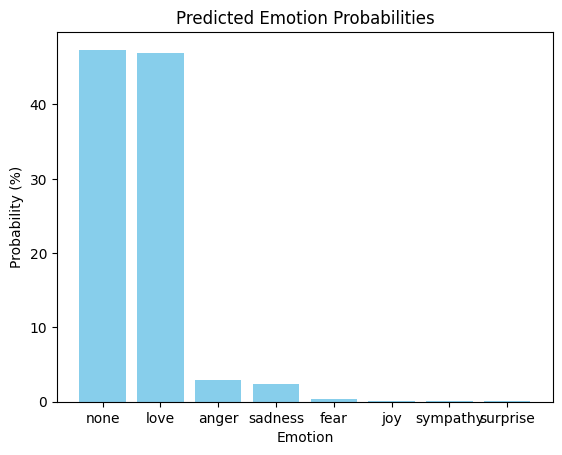

In [ ]:
user_predicted_probabilities = predict_emotion(model_lstm, user_text_padded) #  ---------------------------------------------------------------- using BI-LSTM model

# Display the predicted emotion and probabilities
user_predicted_class = np.argmax(user_predicted_probabilities)
user_predicted_emotion = label_encoder.classes_[user_predicted_class]
user_probabilities_dict = {emotion: round(prob * 100, 2) for emotion, prob in zip(label_encoder.classes_, user_predicted_probabilities)}
user_sorted_probabilities = dict(sorted(user_probabilities_dict.items(), key=lambda item: item[1], reverse=True))

print(f"\nPredicted Emotion: {user_predicted_emotion}")
print("Probabilities:")
for emotion, prob in user_sorted_probabilities.items():
    print(f"{emotion}: {prob}%")

plt.bar(user_sorted_probabilities.keys(), user_sorted_probabilities.values(), color='skyblue')
plt.title('Predicted Emotion Probabilities')
plt.xlabel('Emotion')
plt.ylabel('Probability (%)')
plt.show()

1/1 [==============================] - 0s 25ms/step

Predicted Emotion (CNN): surprise
Probabilities (CNN):
surprise: 16.51%
love: 13.09%
fear: 12.86%
sadness: 12.52%
joy: 12.17%
sympathy: 11.63%
anger: 10.68%
none: 10.54%


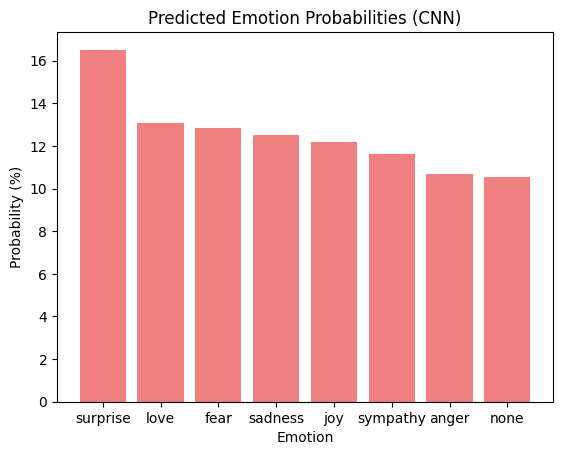

In [ ]:
# Predict with the CNN model
user_predicted_probabilities_cnn = predict_emotion(model_cnn, user_text_padded)  #  ---------------------------------------------------------------- using BI-LSTM model

# Display the predicted emotion and probabilities for CNN model
user_predicted_class_cnn = np.argmax(user_predicted_probabilities_cnn)
user_predicted_emotion_cnn = label_encoder.classes_[user_predicted_class_cnn]
user_probabilities_dict_cnn = {emotion: round(prob * 100, 2) for emotion, prob in zip(label_encoder.classes_, user_predicted_probabilities_cnn)}
user_sorted_probabilities_cnn = dict(sorted(user_probabilities_dict_cnn.items(), key=lambda item: item[1], reverse=True))

print(f"\nPredicted Emotion (CNN): {user_predicted_emotion_cnn}")
print("Probabilities (CNN):")
for emotion, prob in user_sorted_probabilities_cnn.items():
    print(f"{emotion}: {prob}%")

# Plot the bar chart for CNN model
plt.bar(user_sorted_probabilities_cnn.keys(), user_sorted_probabilities_cnn.values(), color='lightcoral')
plt.title('Predicted Emotion Probabilities (CNN)')
plt.xlabel('Emotion')
plt.ylabel('Probability (%)')
plt.show()